In [1]:
from pauls_functions_advanced import *
import pandas as pd
from sklearn.model_selection import train_test_split
from interpretableai import iai
from sklearn.metrics import accuracy_score
from pauls_functions_advanced import *
from itertools import product
from scipy.stats import bernoulli

In [2]:
iters = np.arange(0, 10)
extra_features_possibilities = [0, 1, 2, 5, 10, 20, 50, 100, 200]
accuracies = {f: {i: {} for i in iters} for f in extra_features_possibilities}

In [3]:
# accuracies = pd.DataFrame(np.zeros((20, 3)))
# accuracies.columns = ['OCT', "True Model", 'CART']

names = ['Reg-CART','CART','ORT','OCT','ORT-H','OCT-H']

for extra_features in extra_features_possibilities:

    for i in iters:

        ## Create artificial data set with
        n = 2000
        x1 = np.random.normal(loc = 0,scale=1, size=n)
        x2 = np.random.normal(loc=0, scale=1, size=n)
        x3 = np.random.normal(loc=0, scale=1, size=n)
        x4 = np.random.normal(loc=0, scale=1, size=n)
        x5 = np.random.normal(loc = 0,scale=1, size=n)
        x6 = np.random.normal(loc=0, scale=1, size=n)
        x7 = np.random.normal(loc=0, scale=1, size=n)

        label_not_flipped = np.random.choice([1,0], replace = True, size = n, p = [0.9, 0.1])

        logistic = np.exp(0.5 - 0.5*x3 + 0.4*x2 + 0.25*x1 - 0.3*x7 - 3*(x2 < -0.1) * (x3 > -1)* (x1 < 0.5) + 0.9*(x2 > -0.1)*(x6>-1)*(x5<0.5))

        y = logistic/(1+logistic)
        
        y_bar = bernoulli.rvs(y)

        y = y_bar

        features = {'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 
                                        'x5': x5, 'x6': x6, 'x7': x7,
                                        'y': y, 'y_bar': y_bar}
        
        features.update({f"x{i}": np.random.normal(loc = 0, scale = 1) for i in range(7, 7+extra_features +1)})
        simulated_data = pd.DataFrame(features)
        
        features = simulated_data[[f'x{i}' for i in range(1, 7 + extra_features + 1)]]
        diagnosis = simulated_data['y']
        orig_cols = simulated_data.columns

        X_train, X_test, y_train, y_test = train_test_split(features, diagnosis, test_size = 0.2, random_state=42)

        models, performance = generate_tree(X_train, y_train, X_test, y_test, 
                                            n_num=2, feat_size=extra_features + 7,  max_iter_hy=2, 
                                            depth_bi=4, depth_hy=4, complexity_bi=0.001, 
                                            complexity_hy=0.001, depth_grid_bi=False, depth_grid_hy=False, 
                                            Reg_CART=False, ORT=False, ORT_H=False, 
                                            Clas_CART=True, OCT=True, OCT_H=False)
        
        act_name = []
        act_rules = []
        for model,name in zip(models,names):
            if not not model:
                act_name += [name]
                act_rules += [model]

        datasets = gen_train_and_test_features(act_rules, act_name, X_train, X_test)

        log_reg_acc = log_regression_pipeline(X_train, X_test, y_train, y_test)

        accuracies[extra_features][i]["Logistic Regression"] = log_reg_acc

        for model in datasets.keys():

            X_train_rules_and_features, X_test_rules_and_features = datasets[model][0]
            X_train_only_rules, X_test_only_rules = datasets[model][1]

            only_rules_acc = log_regression_pipeline(X_train_only_rules, X_test_only_rules, y_train, y_test)

            rules_and_features_acc = log_regression_pipeline(X_train_rules_and_features, X_test_rules_and_features, y_train, y_test)

            accuracies[extra_features][i][model + "_rules"] = only_rules_acc
            accuracies[extra_features][i][model + "_rules_and_features"] = rules_and_features_acc
        
            accuracies[extra_features][i]["True Model"] = accuracy_score(y_test, simulated_data['y_bar'].loc[y_test.index])



    ----------------------------------------- section 1 -----------------------------------------


[ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.


Classification CART mean performance:  0.36331611548896026


Classification OCT performance:  0.77




    ----------------------------------------- section 2 -----------------------------------------
Classification CART mean performance:  0.36331611548896026


Classification OCT performance:  0.775




    ----------------------------------------- section 1 -----------------------------------------
Classification CART mean performance:  0.42451437163093786


Classification OCT performance:  0.7725




    ----------------------------------------- section 2 -----------------------------------------
Classification CART mean performance:  0.42451437163093786


Classification OCT performance:  0.7875




    ----------------------------------------- section 1 -----------------------------------------
Classification CART mean performance:  0.39319014461508384


Classification OCT performance:  0.745




    ----------------------------------------- section 2 -------------------------------

In [4]:
dfs = {}

for feature_size in extra_features_possibilities:
    dfs[feature_size] = pd.DataFrame(accuracies[feature_size])

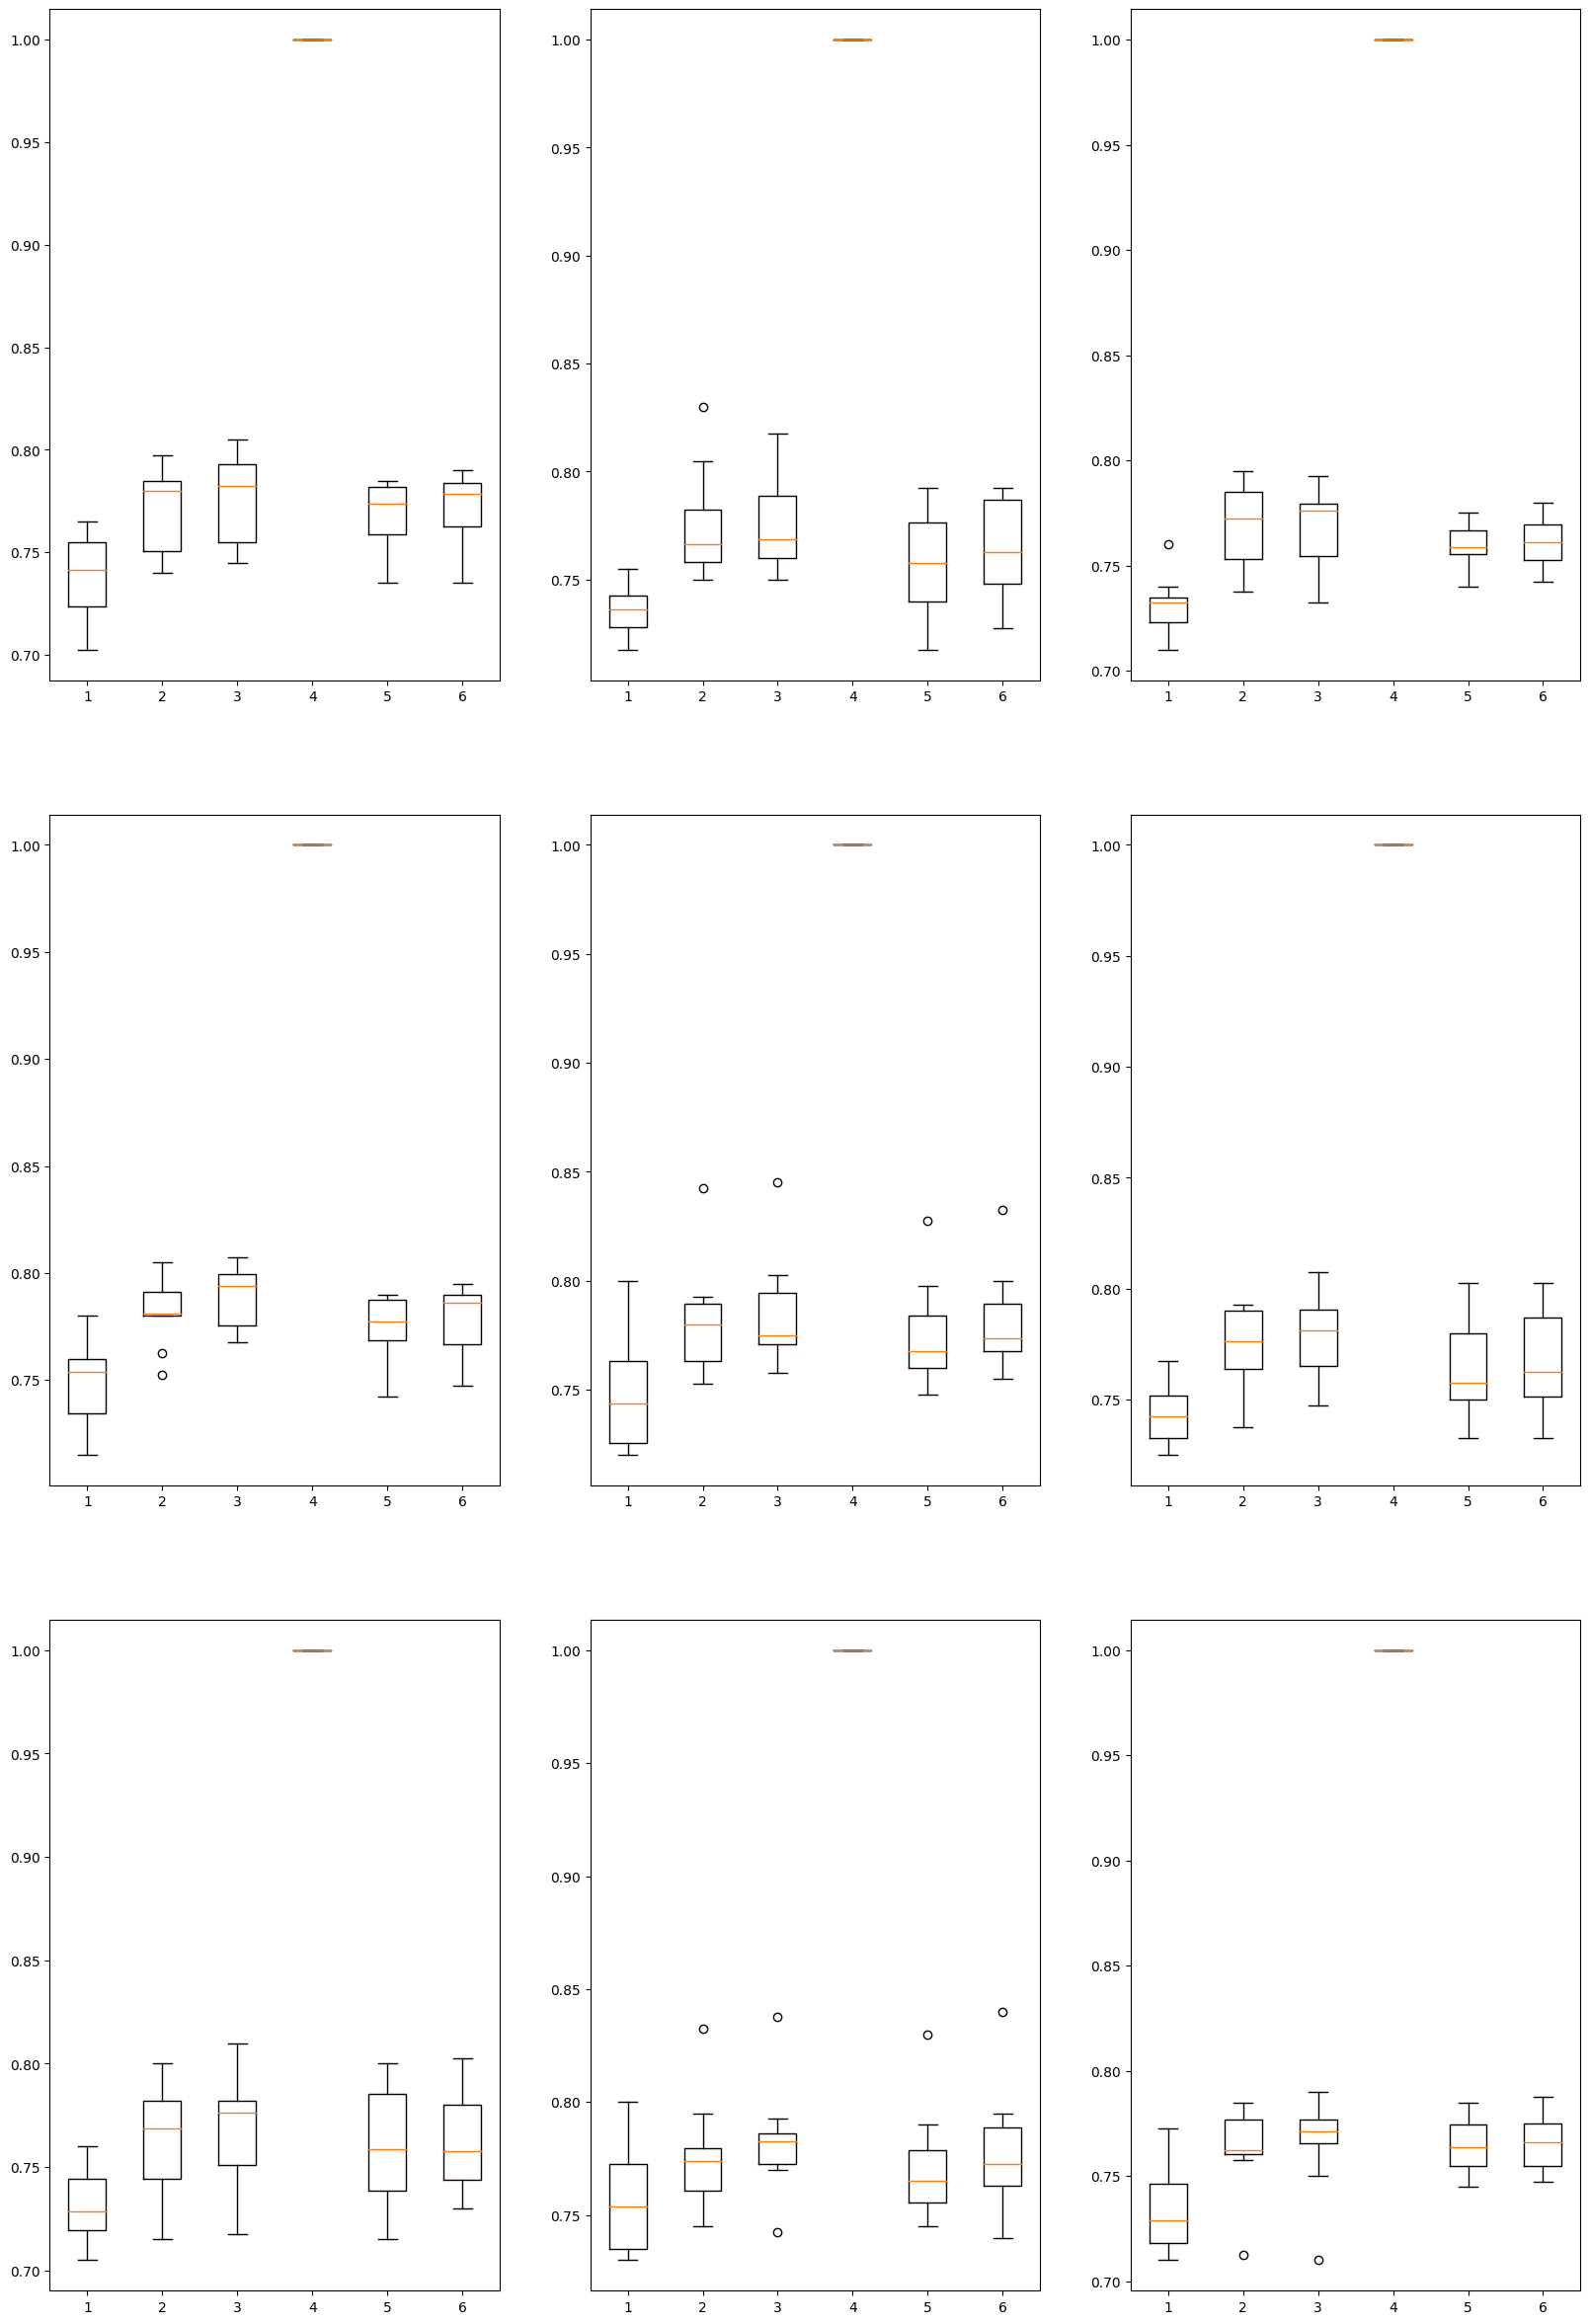

In [5]:
fig, ax= plt.subplots(nrows = 3, ncols = 3)
features = iter(extra_features_possibilities)
fig.set_size_inches(20, 30)
for i in range(3):
    for j in range(3):
        ax[i, j].boxplot(dfs[next(features)].T)

In [6]:
accuracies = pd.DataFrame(accuracies).T.rename(columns = {"CART_rules": "CART", "CART_rules_and_features": "RuleFit", "OCT_rules": "OCT", "OCT_rules_and_features": "ORRFA", "Logistic Regession": "Log. Regression"})

In [7]:
accuracies = accuracies.rename(columns = {"Logistic Regression": "Log. Regression"})

TypeError: unhashable type: 'numpy.ndarray'

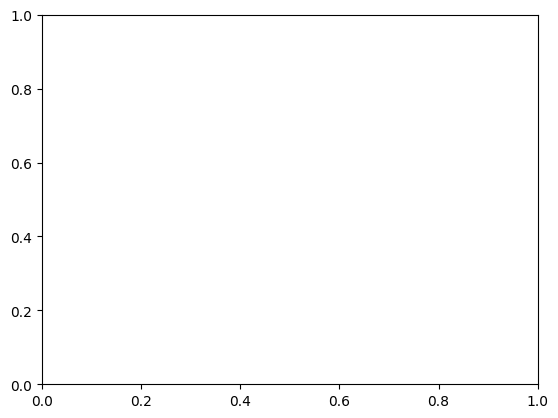

In [8]:
fig, ax= plt.subplots()
# del accuracies['True Model']
ax.plot(accuracies)
ax.legend(accuracies.columns)